In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
import os

In [3]:
parent_dir = os.path.join(os.getcwd(), os.pardir)
sys.path.append(parent_dir)

In [4]:
from src import model
from src import utils

In [5]:
import numpy as np
import pandas as pd
import scipy
import datetime

In [6]:
import pymc3 as pm

In [7]:
import matplotlib.pyplot as plt

In [8]:
df = utils.random_timeseries()

scalers = {}

for col in [col for col in df.columns if col[0] in ['t', 'y']]:
    
    scaler = utils.MinMaxScaler()
    df[col] = scaler.fit_transform(df[col])
    
    scalers[col] = scaler

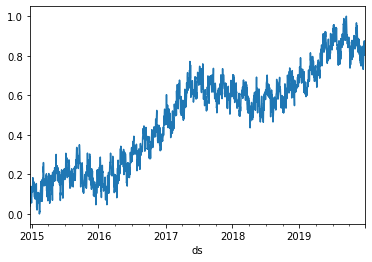

In [9]:
df.set_index(df['ds']).drop(columns=['t', 'ds'])['y_1'].plot()

In [10]:
def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)

In [11]:
def fourier_series(t, p=365.25, n=10):
    # 2 pi n / p
    x = 2 * np.pi * np.arange(1, n + 1) / p
    # 2 pi n / p * t
    x = x * t[:, None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

In [12]:
s = np.linspace(0, 0.8 * np.max(df['t']), 25 + 1)[1:]

# * 1 casts the boolean to integers
# A is a boolean matrix specifying which observation time stamps (vector t) --> rows
# have surpasses which changepoint time stamps (vector s) --> columns
A = (df['t'][:, None] > s) * 1

F_yearly = fourier_series(df['t'], scalers['t'].transform(365.25), 10) # Seasonality w/ yearly period
F_weekly = fourier_series(df['t'], scalers['t'].transform(7), 4) # Seasonality w/ weekly period

In [13]:
# Generate a PyMC3 Model context
model = pm.Model()

In [14]:
with model:
    # Priors
    k = pm.Normal('k', 0, 5)
    m = pm.Normal('m', 0, 5)
    delta = pm.Laplace('delta', 0, 0.05, shape = 25)
    beta_yearly = pm.Normal('beta_yearly', 0, 10, shape = 20)
    beta_weekly = pm.Normal('beta_weekly', 0, 10, shape = 8)
    
    # Model
    
    # Linear trend
    gamma = -s * delta
    mu = (k + det_dot(A, delta)) * df['t'] + (m + det_dot(A, gamma))
    
    # Seasonality
    mu += det_dot(F_yearly, beta_yearly)
    mu += det_dot(F_weekly, beta_weekly)
    
    # Likelihood
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=df['y_1'])
    

In [15]:
with model:
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_weekly, beta_yearly, delta, m, k]
Sampling 4 chains, 974 divergences: 100%|██████████| 4000/4000 [13:16<00:00,  5.02draws/s] 
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 474 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.0979884489724934, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.42368362669418624, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 489 divergences after tuning. Incre

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb766107410>,
      dtype=object)

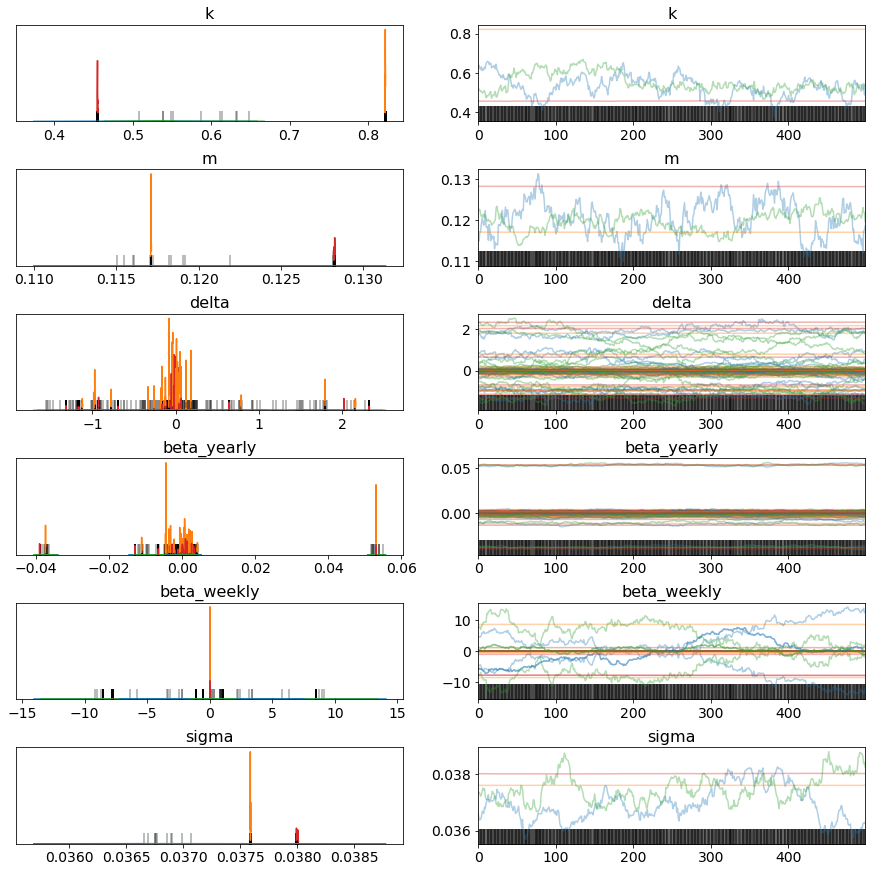

In [16]:
pm.traceplot(trace)

/home/bart/Documents/slimmer/experiments/hierarchical_prophet/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


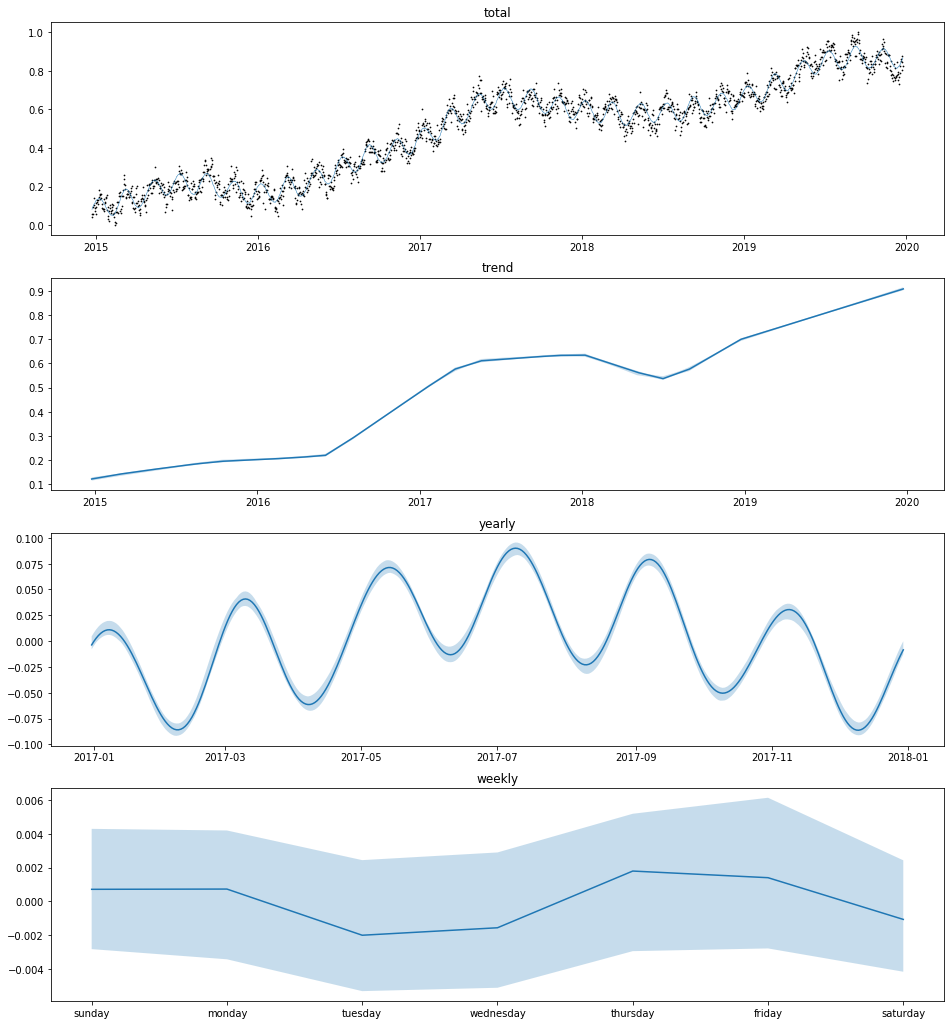

In [24]:
def det_seasonality_posterior(beta, x):
    return np.dot(x, beta.T)

p = 0.025
# vector distributions
beta_yearly = trace['beta_yearly']
beta_weekly = trace['beta_weekly']
delta = trace['delta']

# scalar distributions
k = trace['k']
m = trace['m']

# determine the posterior by evaulating all the values in the trace.
trend_posterior = ((k + np.dot(A, delta.T)) * df['t'][:, None] + m + np.dot(A, (-s * delta).T))

seasonality_yearly = det_seasonality_posterior(beta_yearly, F_yearly)
seasonality_weekly = det_seasonality_posterior(beta_weekly, F_weekly)


date = df['ds'].dt.to_pydatetime()
sunday = np.argmax(df['ds'].dt.dayofweek)
weekdays = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
idx_year = np.argmax(df['ds'].dt.dayofyear)

plt.figure(figsize=(16, 3*6))
b = 411
plt.subplot(b)
plt.title('total')
plt.plot(date,
         (trend_posterior + seasonality_yearly + seasonality_weekly).mean(1), lw=0.5)
plt.scatter(date, df['y_1'], s=0.5, color='black')

plt.subplot(b + 1)
plt.title('trend')
plt.plot(date, trend_posterior.mean(1))
quant = np.quantile(trend_posterior, [p, 1 - p], axis=1)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)

plt.subplot(b + 2)
plt.title('yearly')
plt.plot(date[idx_year: idx_year + 365], seasonality_yearly.mean(1)[idx_year: idx_year + 365])
quant = np.quantile(seasonality_yearly, [p, 1 - p], axis=1)
plt.fill_between(date[idx_year: idx_year + 365],
                 quant[0, idx_year: idx_year + 365], quant[1, idx_year: idx_year + 365], alpha=0.25)

plt.subplot(b + 3)
plt.title('weekly')
plt.plot(weekdays, seasonality_weekly.mean(1)[sunday: sunday + 7])
quant = np.quantile(seasonality_weekly, [p, 1 - p], axis=1)
plt.fill_between(weekdays, quant[0, sunday: sunday + 7],
                 quant[1, sunday: sunday + 7], alpha=0.25)

In [25]:
# Find a point estimate of the models parameters
with model:
    approx = pm.find_MAP()

logp = 3,187, ||grad|| = 844.5: 100%|██████████| 565/565 [00:00<00:00, 718.76it/s]          


In [32]:
def det_seasonality_posterior(beta, x):
    return np.dot(x, beta.T)

p = 0.025
# vector distributions
beta_yearly = approx['beta_yearly']
beta_weekly = approx['beta_weekly']
delta = approx['delta']

# scalar distributions
k = approx['k']
m = approx['m']

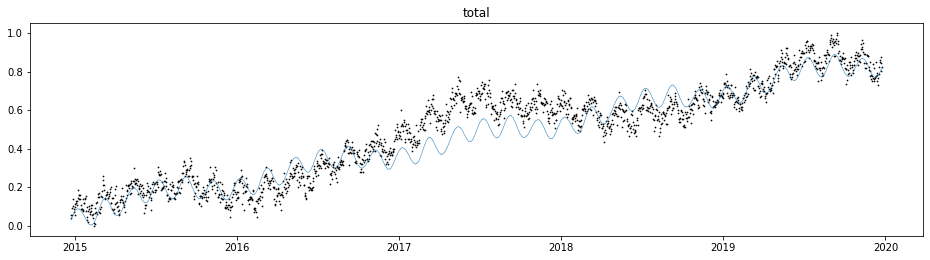

In [37]:
# determine the posterior by evaulating all the values in the trace.
trend_posterior = ((k + np.dot(A, delta.T)) * df['t'][:, None] + m + np.dot(A, (-s * delta).T))

seasonality_yearly = det_seasonality_posterior(beta_yearly, F_yearly) 
seasonality_weekly = det_seasonality_posterior(beta_weekly, F_weekly) 


date = df['ds'].dt.to_pydatetime()
sunday = np.argmax(df['ds'].dt.dayofweek)
weekdays = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
idx_year = np.argmax(df['ds'].dt.dayofyear)

plt.figure(figsize=(16, 3*6))
b = 411
plt.subplot(b)
plt.title('total')
plt.plot(date,
         (trend_posterior.mean(1) + seasonality_yearly + seasonality_weekly), lw=0.5)
plt.scatter(date, df['y_1'], s=0.5, color='black')